In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
from scipy.stats import mstats
%matplotlib inline
plt.style.use("ggplot")

In [2]:
df = pd.read_excel("./data/dose_response.xlsx")
df.head()

,log10 C,death
0,0.95,0
1,0.94,0
2,0.95,0
3,0.96,0
4,0.99,0


Text(0, 0.5, 'death')

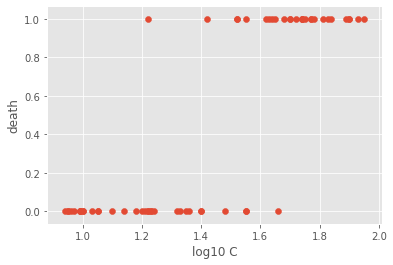

In [3]:
plt.scatter(df["log10 C"], df["death"])
plt.xlabel("log10 C")
plt.ylabel("death")

In [4]:
stan_model = """
data {
    int N;
    real X[N];
    int<lower=0, upper=1> Y[N];
}

parameters {
    real a;
    real b;
}

model {
    for (n in 1:N) {
        Y[n] ~ bernoulli_logit(a * X[n] + b);
    }
}
"""

In [5]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e818975037ba9517c5bcb75b24894cc1 NOW.


In [6]:
stan_data = {"N": df.shape[0], "X": df["log10 C"], "Y": df["death"]}

In [7]:
fit = sm.sampling(data=stan_data, iter=2000, warmup=500, chains=3, seed=123)

In [8]:
fit

Inference for Stan model: anon_model_e818975037ba9517c5bcb75b24894cc1.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     13.83    0.14   3.51   8.46  11.33  13.41  15.84  22.06    649    1.0
b    -20.64    0.21   5.32 -33.18 -23.65 -19.97 -16.86 -12.44    645    1.0
lp__ -14.95    0.04    1.1 -17.78 -15.38 -14.61 -14.16 -13.89    937    1.0

Samples were drawn using NUTS at Sat Aug 24 22:15:09 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [9]:
a, b = 13.87, -20.64

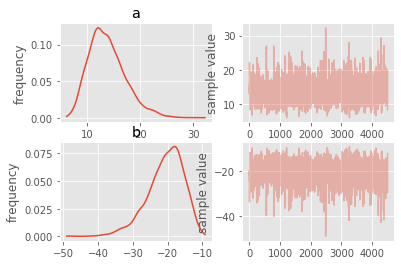

In [10]:
fig = fit.plot()

In [14]:
ms_a = fit.extract("a")["a"]
ms_b = fit.extract("b")["b"]

In [15]:
x = np.arange(1.00, 2.01, 0.01)
f = lambda x: 1.0 / (1.0 + np.exp(-x))
df_b = pd.DataFrame([])

for i in range(x.shape[0]):
    df_b[i] = f(ms_a * x[i] + ms_b)

df_b.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.008296,0.009070,0.009915,0.010838,0.011846,0.012947,0.014148,0.015459,0.016890,0.018450,...,0.967769,0.970460,0.972932,0.975203,0.977288,0.979201,0.980956,0.982566,0.984042,0.985395
1,0.001538,0.001767,0.002030,0.002332,0.002679,0.003078,0.003536,0.004061,0.004664,0.005356,...,0.997936,0.998204,0.998437,0.998639,0.998816,0.998969,0.999103,0.999220,0.999321,0.999409
2,0.000482,0.000561,0.000652,0.000758,0.000881,0.001025,0.001191,0.001385,0.001611,0.001873,...,0.997759,0.998073,0.998342,0.998574,0.998774,0.998945,0.999093,0.999220,0.999329,0.999423
3,0.004109,0.004567,0.005076,0.005642,0.006270,0.006968,0.007743,0.008603,0.009558,0.010618,...,0.984863,0.986367,0.987724,0.988948,0.990050,0.991044,0.991939,0.992746,0.993472,0.994126
4,0.000020,0.000026,0.000032,0.000040,0.000050,0.000062,0.000078,0.000097,0.000121,0.000152,...,0.999924,0.999939,0.999951,0.999961,0.999969,0.999975,0.999980,0.999984,0.999987,0.999990


In [16]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)

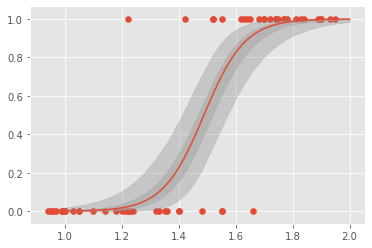

In [17]:
plt.scatter(df["log10 C"], df["death"])
plt.fill_between(x, low_y95, high_y95, alpha=0.3, color="gray")
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.plot(x, f(a * x + b))

前回と異なり，今回はデータが均等にばらけているため，信頼区間は一定に近い